Very dumbed-down version of what they do here: "Experimental Bayesian Calibration of Trapped-Ion Entangling Operations" (https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.3.020350).

- Instead of a simultaneous 4D calibration, here we do 4 1D calibrations. 
- Instead of cubic-spline interpolation, we do direct sampling. 
- Instead of a variable measurement strategy that minimizes the variance of the posterior based on sensitivity to phase and Rabi frequency, we go with a constant measurement strategy. 

Original noise parameters ($\sigma_\Omega, \sigma_\Delta, \sigma_\epsilon, \sigma_\varphi$) based on the original paper (see Fig. 4)

Derivative noise parameters ($\sigma_I, \sigma_{f_{cl}}, \sigma_{\nu}$) based on **single_qubit_rotations/single_qubit_noise_sim.ipynb**.

In [1]:
# Run this cell to test if the LinearChain object is gonna give us a headache.
using IonSim

@time chain = LinearChain(
        ions=[Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")]), Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])], 
        comfrequencies=(x=3e6,y=3e6,z=2.5e5), selectedmodes=(;z=[1],)
    )
chain = Nothing;

  7.351566 seconds (14.89 M allocations: 957.793 MiB, 9.55% gc time, 99.79% compilation time: <1% of which was recompilation)


In [468]:
using QuantumOptics
import PyPlot
using Random, Distributions
using ProgressBars
Random.seed!(0)

include("./molmer_sorensen.jl")
using .MolmerSorensen: construct_MS_chamber
const plt = PyPlot;

using DelimitedFiles

The Molmer-Sorensen Hamiltonian: $\hat{H} = \frac{\Omega(t)}{2} \sum_{i=1,2} \Bigg[ \bigg( \hat{\sigma}_+^{(1)} + \hat{\sigma}_+^{(2)} \bigg) \otimes e^{i[\eta(\hat{a} e^{-i\nu t} + \hat{a}^\dagger e^{i \nu t} ) - \Delta_i t + \phi_i ) ] } \Bigg] + h.c.$

## 0. Setup

Global variables

In [470]:
######################### Intensity #########################
Œº_I = 94326.65907221894 # W/cm^2
œÉ_I = 38106.10236476285 # W/cm^2
Normal_I = Normal(Œº_I, œÉ_I)

######################### Trap frequency #########################
Œº_ŒΩ = 2.5e5 # Hz
œÉ_ŒΩ = 2e3 # Hz
Normal_ŒΩ = Normal(Œº_ŒΩ, œÉ_ŒΩ)

######################### Center-line frequency #########################
C0 = 2.99792458e8
Œ¥Œª_MAX = 1e-15
Œº_f_cl = 4.111550352057269e14 # Hz
œÉ_f_cl = 2e3 # Hz
Normal_f_cl = Normal(Œº_f_cl, œÉ_f_cl)

######################### Phase #########################
Œº_œï = 0
œÉ_œï = 0.16*œÄ
Normal_œï = Normal(Œº_œï, œÉ_œï)

######################### Other chamber parameters #########################
DETUNING = 1e4 # Hz
AC_CORRECTION = 0; # Hz
B_STRENGTH = 0.0005999899999999999; # T

GATE_TIME = 1/DETUNING # seconds
T_RANGE = 0:GATE_TIME*1e-3:GATE_TIME
TIMESCALE = 1e-6 # seconds 

######################### Other global variables #########################
FID_THRESH = 1 - 1.2e-3
MAX_LOOPS = 200
N_SHOTS = 100

CALCIUM40 = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])
N_PARTICLES = Int(1e3)
FINITE_RWA_CUTOFF = 1e5

# Intialize chamber object, whose properties will be updated in the loop
MS_CHAMBER_TUNED = construct_MS_chamber(
    Œº_ŒΩ,
    Œº_I,
    C0/Œº_f_cl,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
phase!(MS_CHAMBER_TUNED.lasers[1], 0)
phase!(MS_CHAMBER_TUNED.lasers[2], 0)

ket0_VIB_MODE = IonSim.modes(MS_CHAMBER_TUNED)[1][0] # ground state of first vibrational mode
dm0_VIB_MODE = dm(ket0_VIB_MODE)

# Computational states 
ket_00 = CALCIUM40["S"] ‚äó CALCIUM40["S"]
ket_01 = CALCIUM40["S"] ‚äó CALCIUM40["D"]
ket_10 = CALCIUM40["D"] ‚äó CALCIUM40["S"]
ket_11 = CALCIUM40["D"] ‚äó CALCIUM40["D"]
œÅ_00 = dm(ket_00)
œÅ_01 = dm(ket_01)
œÅ_10 = dm(ket_10)
œÅ_11 = dm(ket_11)

# Bell states 
ket_00_m_i11 = (ket_00 - 1im*ket_11)/‚àö2
ket_00_p_i11 = (ket_00 + 1im*ket_11)/‚àö2
ket_01_m_i10 = (ket_01 - 1im*ket_10)/‚àö2
ket_01_p_i10 = (ket_01 + 1im*ket_10)/‚àö2
œÅ_00_m_i11 = dm(ket_00_m_i11)
œÅ_00_p_i11 = dm(ket_00_p_i11)
œÅ_01_m_i10 = dm(ket_01_m_i10)
œÅ_01_p_i10 = dm(ket_01_p_i10)

œÅ_TARGET = dm(ket_00_p_i11 ‚äó ket0_VIB_MODE);

Helper functions 

In [471]:
# For loading CSV's into matrices 
function load_csv_to_matrix(fname)
    data = readdlm(fname)
    data = [split(line, ",") for line in data]
    data = [[parse(Float64, elem) for elem in row] for row in data]

    matrix = zeros((length(data), length(data[1])))
    for i in 1:length(data)
        matrix[i,:] = [elem for elem in data[i]]
    end
    return matrix
end

# For measuring ZZ
function ZZ_probs(œàf) # random projective measurement onto the computational basis
    p_00 = real(tr( (œÅ_00 ‚äó dm0_VIB_MODE) * œàf))
    p_11 = real(tr( (œÅ_00 ‚äó dm0_VIB_MODE) * œàf))
    p_01 = real(tr( (œÅ_00 ‚äó dm0_VIB_MODE) * œàf))
    p_10 = real(tr( (œÅ_00 ‚äó dm0_VIB_MODE) * œàf))

    return p_00, p_11, p_01, p_10
end

# For plotting state populations 
function plot_populations_double(chamber, tout, sol; title = Nothing)

    # compute expectation values
    prob_00 = expect(œÅ_00 ‚äó dm0_VIB_MODE , sol)  # ùîº(|S‚ü©|S‚ü©)
    prob_11 = expect(œÅ_11 ‚äó dm0_VIB_MODE, sol)  # ùîº(|D‚ü©|D‚ü©)
    prob_01 = expect(œÅ_01 ‚äó dm0_VIB_MODE, sol)  # ùîº(|S‚ü©|D‚ü©)
    prob_10 = expect(œÅ_10 ‚äó dm0_VIB_MODE, sol)  # ùîº(|D‚ü©|S‚ü©)
    prob_00_p_i11 = expect(œÅ_00_p_i11 ‚äó dm0_VIB_MODE, sol)  # ùîº(|S‚ü©|S‚ü© + i|D‚ü©|D‚ü©)
    prob_00_m_i11 = expect(œÅ_00_m_i11 ‚äó dm0_VIB_MODE, sol)  # ùîº(|S‚ü©|S‚ü© - i|D‚ü©|D‚ü©)
    prob_01_p_i10 = expect(œÅ_01_p_i10 ‚äó dm0_VIB_MODE, sol)  # ùîº(|S‚ü©|D‚ü© + i|D‚ü©|S‚ü©)
    prob_01_m_i10 = expect(œÅ_01_m_i10 ‚äó dm0_VIB_MODE, sol)  # ùîº(|S‚ü©|D‚ü© - i|D‚ü©|S‚ü©)

    # plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(tout, prob_00, label="00")
    ax1.plot(tout, prob_11, label="11")
    ax1.plot(tout, prob_01, label="01")
    ax1.plot(tout, prob_10, label="10")
    ax1.set_xlim(tout[1], tout[end])
    ax1.set_ylim(0, 1)
    ax1.legend(loc=1)
    ax1.set_xlabel("Time (Œºs)")
    ax1.set_ylabel("Population")
    ax1.set_title("Computational basis states")

    ax2.plot(tout, prob_00_p_i11, label="00 + i11")
    ax2.plot(tout, prob_00_m_i11, label="00 - i11")
    ax2.plot(tout, prob_01_p_i10, label="01 + i10")
    ax2.plot(tout, prob_01_m_i10, label="01 - i10")
    ax2.set_xlim(tout[1], tout[end])
    ax2.set_ylim(0, 1)
    ax2.legend(loc=1)
    ax2.set_xlabel("Time (Œºs)")
    ax2.set_ylabel("Population")
    ax2.set_title("Bell states")
    if title != Nothing
        fig.suptitle(title)
    end

    return fig
end

# For binning probability distributions
function bin_prior(particles, weights, n_bins)
    new_bins = zeros(n_bins)
    new_weights = zeros(n_bins)
    bin_width = (maximum(particles) - minimum(particles))/n_bins
    
    for i in 1:n_bins
        bin_start = minimum(particles) + (i-1)*bin_width
        bin_end = bin_start + bin_width
        new_bins[i] = mean([bin_start, bin_end])

        bin_filter = (particles .>= bin_start).&(particles .< bin_end)
        weight_in_bin = sum(weights[bin_filter])
        new_weights[i] = weight_in_bin
        
    end
    return new_bins, new_weights, bin_width
end

bin_prior (generic function with 1 method)

Test fidelity with optimal parameters

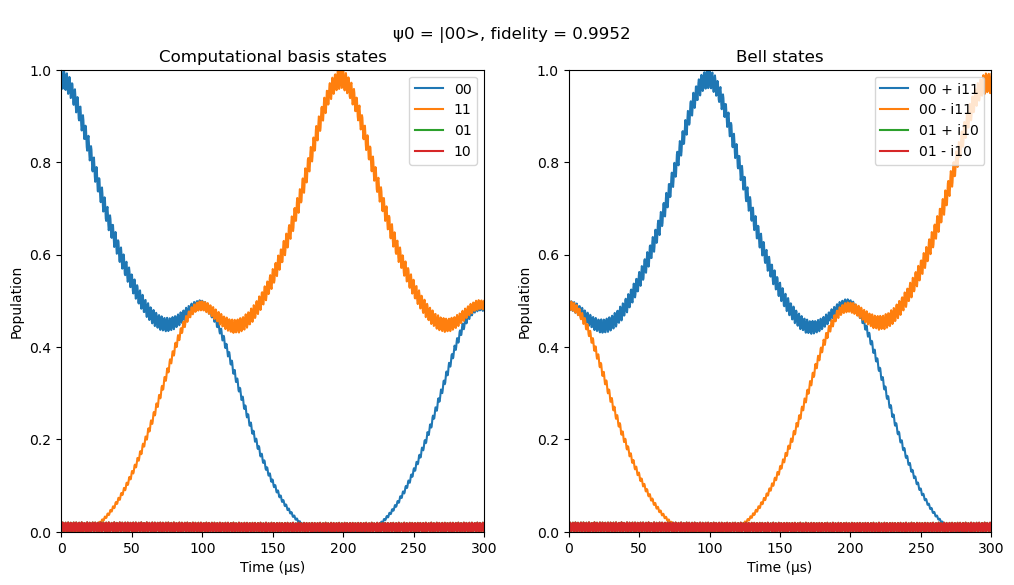

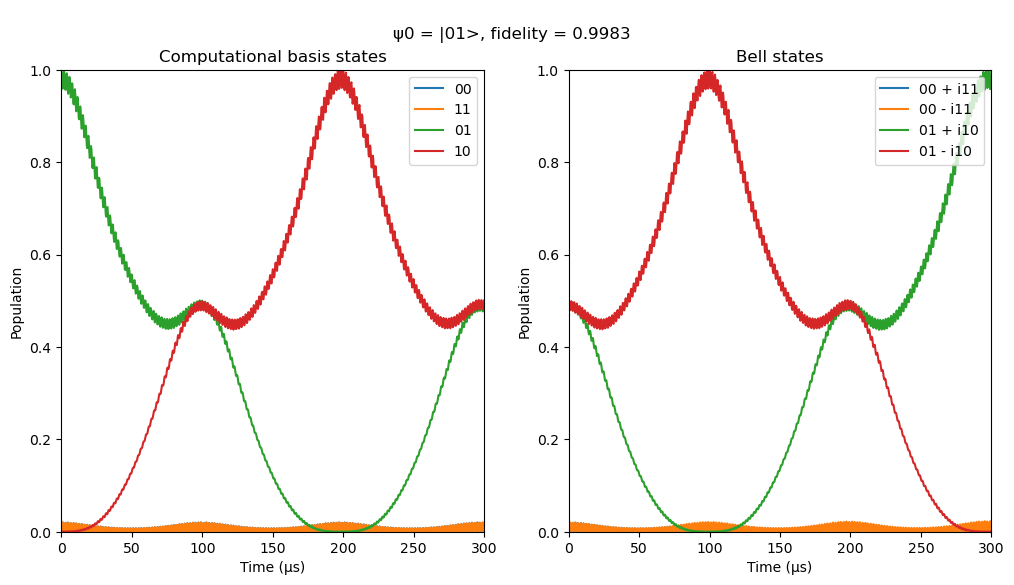

In [472]:
h = hamiltonian(MS_CHAMBER_TUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf);

@time tout00, sol00 = timeevolution.schroedinger_dynamic(3*T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h);
œÅ_final = ptrace(dm(sol00[end]), 3)
fid = round(real(fidelity(œÅ_final, œÅ_00_m_i11)), digits=4)
fig = plot_populations_double(MS_CHAMBER_TUNED, tout00, sol00)
fig.suptitle("\nœà0 = |00>, fidelity = $fid")
plt.display(fig)
plt.close(fig)

@time tout01, sol01 = timeevolution.schroedinger_dynamic(3*T_RANGE/TIMESCALE, ket_01 ‚äó ket0_VIB_MODE , h);
œÅ_final = ptrace(dm(sol01[end]), 3)

fid = round(real(fidelity(œÅ_final, œÅ_01_p_i10)), digits=4)
fig = plot_populations_double(MS_CHAMBER_TUNED, tout01, sol01)
fig.suptitle("\nœà0 = |01>, fidelity = $fid")
plt.display(fig)
plt.close(fig)


Functions to update true parameters, given measured parameters

1. Intensity
$\kappa = \frac{I}{\Omega^2} \Longrightarrow \Omega^2 = \frac{I}{\kappa} \Longrightarrow \Omega = \sqrt{\frac{I}{\kappa}}$

    $\frac{\Omega_{\text{opt}}}{\overline{\Omega}} = \frac{\sqrt{I_{\text{opt}}/\kappa}}{\sqrt{\overline{I}/\kappa}} = \sqrt{\frac{I_{\text{opt}}}{\overline{I}}}$

    In the text, they update: $t_g \to t_g \frac{\Omega_{\text{opt}}}{\overline{\Omega}}$

    Since $t_g \sim I$, here we will update: $\boxed{I \to I \sqrt{\frac{I_{\text{opt}}}{\overline{I}}}}$

2. Center-line frequency

    In the text, they update: $f_{\text{cl}} \to f_{\text{cl}} - (  \overline{\omega}_{\text{cl}} - \omega_{\text{cl, opt}} )$. 

    **Mind the confusing notation**: here, $\omega_{\text{cl}}$ is not an angular frequency, they just use $\omega$ to denote the center-line *detuning* as opposed to the center-line frequency. With this in mind, it's clear that $\overline{\omega}_{\text{cl}} - \omega_{\text{cl, opt}}$ is exactly equivalent to $ \overline{f}_{\text{cl}} - f_{\text{cl, opt}}$. 

    So we will update: $\boxed{f_{\text{cl}} \to f_{\text{cl}} - ( \overline{f}_{\text{cl}} - f_{\text{cl, opt}} )}$

3. Trap-frequency

    In the text, they update: $f_{\text{sb}} \to f_{\text{sb}} - ( \overline{\delta} - \delta_{\text{opt}})$

    So, once again, we simply update: $\boxed{\nu \to \nu - (\overline{\nu} - \nu_{\text{opt}})}$

4. Phase
    $\boxed{\varphi \to \varphi - (\overline{\Delta \varphi} - \Delta \varphi_{\text{opt}})}$

In [473]:
# Intensity
function compute_I_new(chamber, I_bar)
    I = chamber.lasers[1].I(0)
    return I*sqrt(Œº_I/I_bar)
end

function update_intensity(chamber, I_new)
    intensity!(chamber.lasers[1], I_new)
    intensity!(chamber.lasers[2], I_new)
end

# Center-line frequency 
function compute_f_cl_new(chamber, f_cl_bar)
    Œª_cl = chamber.lasers[1].Œª
    f_cl = C0/Œª_cl
    return f_cl - (f_cl_bar - Œº_f_cl)
end

function update_f_cl(chamber, f_cl_new)
    wavelength!(chamber.lasers[1], C0/f_cl_new)
    wavelength!(chamber.lasers[2], C0/f_cl_new)
end

# Trap-frequency
function compute_ŒΩ_new(chamber, ŒΩ_bar)
    ŒΩ = chamber.iontrap.comfrequencies.z
    return ŒΩ - (ŒΩ_bar - Œº_ŒΩ)
end

function update_ŒΩ(chamber, ŒΩ_new)
    # Can't update the trap-frequency in-place
    # Must create a brand new chamber, with all the same properties except for the trap frequency
    I = chamber.lasers[1].I(0)
    Œª_cl = chamber.lasers[1].Œª
    chamber_new = construct_MS_chamber(
        ŒΩ_new,
        I,
        Œª_cl,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH
    )

    # Recall: The detuning is based on the *target* trap-frequency
    chamber.lasers[1].Œî = Œº_ŒΩ + DETUNING - AC_CORRECTION
    chamber.lasers[2].Œî = -(Œº_ŒΩ + DETUNING - AC_CORRECTION)
    return chamber_new
end 

# Phase
function compute_œï_new(chamber, œï_bar)
    œï = chamber.lasers[2].œï(0)
    return œï - (œï_bar - Œº_œï)
end

function update_œï(chamber, œï_new)
    phase!(chamber.lasers[2], œï_new)
end
 

update_œï (generic function with 1 method)

# 1. Precompute conditional probability densities

## 1.a. Define our measurement protocol $m$

"We restrict our considerations to sequences of MS gates without any local operations. Besides the number of gates $N_g$ we can also intentionally introduce a phase difference $\Delta \varphi_{\text{target}}$ between the gates. We restrict the phase difference settings to either $\Delta \varphi_{\text{target}} = 0$ or $\Delta \varphi_{\text{target}} = \pm \pi/4$, corresponding to either consecutive $U_{\text{MS}}^0 (\pi/2)$ gates or a sequence of $U_{\text{MS}}^0 (\pi/2) U_{\text{MS}}^{\pm \pi/4} (\pi/2) ... U_{\text{MS}}^{\pm (N_g-1)\pi/4} (\pi/2) $ gates. We choose these two types of sequences as they change which parameters the sequence is most sensitive to (Fig. 6)."

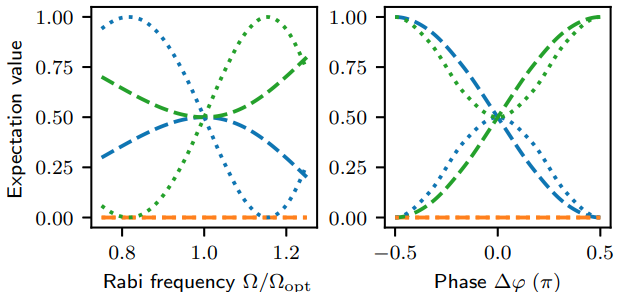

"FIG. 6. Expected outcome probabilities of $P(\ket{|g, g})$ (green), $P(\ket{|e, e})$  (blue), and $P(\ket{|e, g})  + P(\ket{|g, e})$ (orange) for a 3 $U_{\text{MS}}^0 (\pi/2)$ gate sequence (dotted) and for a $ U_{\text{MS}}^0 (\pi/2) U_{\text{MS}}^{\pi/4} (\pi/2) $ sequence (dashed). The first gate sequence is first-order insensitive to phase miscalibrations as the local minimum of the outcome probabilities around zero leads to only small variations in the likelihood of possible outcomes, and its symmetry around zero does not allow one to discriminate the sign of the miscalibration. Similar arguments can be used to see that this sequence is first-order sensitive to Rabi frequency miscalibrations. For the second gate sequence, the relation is inverted, being sensitive to phase miscalibrations at the cost of first-order insensitivity to the Rabi frequency. The qualitative behavior of the sensitivity of the center line matches the sensitivity of the phase difference, while the behavior of the sideband detuning matches the Rabi frequency."

Since we're not varying phase right now, let's stick with the first sequence of gates:
$N_g = 3 \Longrightarrow \boxed{m = U_{\text{MS}}^0 (\pi/2) U_{\text{MS}}^0 (\pi/2) U_{\text{MS}}^0 (\pi/2)} = U_{\text{MS}}^0 (3\pi/2)$

**TODO**: Consider a weighted-combination of Rabi-sensitive and phase-sensitive gates

**TODO**: Consider 50-50 split of $\psi_{\text{target}} = \frac{1}{\sqrt{2}} \left(\ket{00} + i\ket{11}\right)$ and $\psi_{\text{target}} = \frac{1}{\sqrt{2}} \left(\ket{01} + i\ket{10}\right)$ (or something else since this assumes perfect preparation of the initial state?)

## 1.b. Compute $P(m|\widetilde{\Theta}^{(i)})$ by sampling $\texttt{particles\_X\_1d}$ and numerically integrating at that point.

**TODO:** Introduce depolarizing noise to account for SPAM error.

There are two ways to *obtain* these $P(m|\widetilde{\Theta}^{(i)})$:
1. Numerical simulation at each discrete sample point.
2. Numerical simulation of an equally-spaced grid, then interpolation. 

In the paper, they go with the later because it's computationally cheaper. 

Here, we will go with the former because it's simpler and we are only calibrating one parameter.

In [474]:
CONDITIONAL_DISTRIBUTIONS_COMPUTED = true

true

In [475]:
# Compute initial prior
particles_I_1d = []
weights_I_1d = []
n_collected_I_1d = 0
while n_collected_I_1d < N_PARTICLES
    I_new = rand(Normal_I)[1]
    if I_new<0
        continue
    end
    append!(particles_I_1d, I_new)
    append!(weights_I_1d, 1.0)
    n_collected_I_1d += 1
end
weights_I_1d = weights_I_1d ./ sum(weights_I_1d);
weights_I_1d_initial = deepcopy(weights_I_1d);
particles_I_1d_initial = deepcopy(particles_I_1d);

# Compute initial prior
particles_f_cl_1d = []
weights_f_cl_1d = []
n_collected_f_cl_1d = 0
while n_collected_f_cl_1d < N_PARTICLES
    f_cl_new = rand(Normal_f_cl)[1]
    Œª_cl_new = C0/f_cl_new
    Œ¥Œª_cl_new = abs(C0/Œº_f_cl - Œª_cl_new)
    if Œ¥Œª_cl_new > Œ¥Œª_MAX
        continue
    end
    append!(particles_f_cl_1d, f_cl_new)
    append!(weights_f_cl_1d, 1.0)
    n_collected_f_cl_1d += 1
end
weights_f_cl_1d = weights_f_cl_1d ./ sum(weights_f_cl_1d);
weights_f_cl_1d_initial = deepcopy(weights_f_cl_1d);
particles_f_cl_1d_initial = deepcopy(particles_f_cl_1d);

# Compute initial prior
particles_ŒΩ_1d = []
weights_ŒΩ_1d = []
n_collected_ŒΩ_1d = 0
while n_collected_ŒΩ_1d < N_PARTICLES
    ŒΩ_new = rand(Normal_ŒΩ)[1]
    append!(particles_ŒΩ_1d, ŒΩ_new)
    append!(weights_ŒΩ_1d, 1.0)
    n_collected_ŒΩ_1d += 1
end
weights_ŒΩ_1d = weights_ŒΩ_1d ./ sum(weights_ŒΩ_1d);
weights_ŒΩ_1d_initial = deepcopy(weights_ŒΩ_1d);
particles_ŒΩ_1d_initial = deepcopy(particles_ŒΩ_1d);

# Compute initial prior
particles_œï_1d = []
weights_œï_1d = []
n_collected_œï_1d = 0
while n_collected_œï_1d < N_PARTICLES
    œï_new = rand(Normal_œï)[1]
    append!(particles_œï_1d, œï_new)
    append!(weights_œï_1d, 1.0)
    n_collected_œï_1d += 1
end
weights_œï_1d = weights_œï_1d ./ sum(weights_œï_1d);
weights_œï_1d_initial = deepcopy(weights_œï_1d);
particles_œï_1d_initial = deepcopy(particles_œï_1d);

if CONDITIONAL_DISTRIBUTIONS_COMPUTED
    m_given_I_1d_dist = load_csv_to_matrix("m_given_I_1d_dist_$N_PARTICLES.csv")
    m_given_f_cl_1d_dist = load_csv_to_matrix("m_given_f_cl_1d_dist_$N_PARTICLES.csv")
    m_given_ŒΩ_1d_dist = load_csv_to_matrix("m_given_ŒΩ_1d_dist_$N_PARTICLES.csv")
    #m_given_œï_1d_dist = load_csv_to_matrix("m_given_œï_1d_dist_$N_PARTICLES.csv")
else
    print("Computing conditional distributions...")
    flush(stdout)

    print("\nI...")
    flush(stdout)
    MS_CHAMBER_UNTUNED = construct_MS_chamber(
        Œº_ŒΩ,
        Œº_I,
        C0/Œº_f_cl,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH
    )
    phase!(MS_CHAMBER_UNTUNED.lasers[1], Œº_œï)
    phase!(MS_CHAMBER_UNTUNED.lasers[2], Œº_œï)
    m_given_I_1d_dist = zeros((N_PARTICLES, 4))
    for i in 1:N_PARTICLES
        I_i = particles_I_1d[i]
        update_intensity(MS_CHAMBER_UNTUNED, I_i)
        h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
        tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
        œÅ_final = dm(sol[end])
        probs = ZZ_probs(œÅ_final)
        probs = probs ./ sum(probs)
        m_given_I_1d_dist[i, :] = [p for p in probs]
    end
    writedlm("m_given_I_1d_dist_$N_PARTICLES.csv",  m_given_I_1d_dist, ',')

    print("\nf_cl...")
    flush(stdout)
    m_given_f_cl_1d_dist = zeros((N_PARTICLES, 4))
    MS_CHAMBER_UNTUNED = construct_MS_chamber(
        Œº_ŒΩ,
        Œº_I,
        C0/Œº_f_cl,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH
    )
    phase!(MS_CHAMBER_UNTUNED.lasers[1], Œº_œï)
    phase!(MS_CHAMBER_UNTUNED.lasers[2], Œº_œï)
    m_given_f_cl_1d_dist = zeros((N_PARTICLES, 4))
    for i in 1:N_PARTICLES
        f_cl_i = particles_f_cl_1d[i]
        update_f_cl(MS_CHAMBER_UNTUNED, f_cl_i)
        h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
        tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
        œÅ_final = dm(sol[end])
        probs = ZZ_probs(œÅ_final)
        probs = probs ./ sum(probs)
        m_given_f_cl_1d_dist[i, :] = [p for p in probs]
    end
    writedlm("m_given_f_cl_1d_dist_$N_PARTICLES.csv",  m_given_f_cl_1d_dist, ',')
    
    print("\nŒΩ...")
    flush(stdout)
    m_given_ŒΩ_1d_dist = zeros((N_PARTICLES, 4))
    MS_CHAMBER_UNTUNED = construct_MS_chamber(
        Œº_ŒΩ,
        Œº_I,
        C0/Œº_f_cl,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH
    )
    m_given_ŒΩ_1d_dist = zeros((N_PARTICLES, 4))
    for i in 1:N_PARTICLES
        try
            ŒΩ_i = particles_ŒΩ_1d[i]
            MS_CHAMBER_UNTUNED = update_ŒΩ(MS_CHAMBER_UNTUNED, ŒΩ_i)
            h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
            tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
            œÅ_final = dm(sol[end])
            probs = ZZ_probs(œÅ_final)
            probs = probs ./ sum(probs)
            m_given_ŒΩ_1d_dist[i, :] = [p for p in probs]
        catch
            m_given_ŒΩ_1d_dist[i, :] = [NaN for p in 1:4]
            particles_ŒΩ_1d[i] = NaN
            weights_ŒΩ_1d[i] = NaN
        end
    end
    writedlm("m_given_ŒΩ_1d_dist_$N_PARTICLES.csv",  m_given_ŒΩ_1d_dist, ',')
    
    print("\nœï...")
    flush(stdout)
    m_given_œï_1d_dist = zeros((N_PARTICLES, 4))
    MS_CHAMBER_UNTUNED = construct_MS_chamber(
        Œº_ŒΩ,
        Œº_I,
        Œº_f_cl,
        DETUNING,
        AC_CORRECTION,
        B_STRENGTH
    )
    phase!(MS_CHAMBER_UNTUNED.lasers[1], 0)
    m_given_œï_1d_dist = zeros((N_PARTICLES, 4))
    for i in 1:length(particles_œï_1d)
        œï_i = particles_œï_1d[i]
        phase!(MS_CHAMBER_UNTUNED.lasers[2], œï_i)
        h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
        tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
        œÅ_final = dm(sol[end])
        probs = ZZ_probs(œÅ_final)
        probs = probs ./ sum(probs)
        m_given_œï_1d_dist[i, :] = [p for p in probs]
    end
    writedlm("m_given_œï_1d_dist_$N_PARTICLES.csv",  m_given_œï_1d_dist, ',')

    CONDITIONAL_DISTRIBUTIONS_COMPUTED = true
    
end;

# 2. Calibrating: Intensity

**Paper**: "The Bayesian inference requires an initial prior (i.e. $P(\Theta)$), and we must choose an initial set of particles to represent this prior. We choose a known continuous probability density function as prior."

**Here**: $\Theta = (I) \Longrightarrow P(\Theta) \sim \mathcal{N}(\mu_I, \sigma_I) \Longrightarrow \boxed{P(\Theta) = \frac{1}{\sqrt{2\pi \sigma_I}} \exp\left[-\frac{1}{2}  \frac{(i - \mu_I)^2}{\sigma_I^2} \right]}  $

**Paper**: "We can then initialize the particle filter from that probability function by randomly sampling $N_p$ times from the distribution and setting all the weights to $1/N_p$."

**Here**: the $\texttt{weights\_I\_1d}$ distribution is what gets updated throughout the calibration process. At each sample point $\widetilde{\Theta}^{(i)} \in \texttt{particles\_I\_1d}$, the relevant weight $w^{(i)} \in \texttt{weights\_1d}$ is updated according to $w_m^{(i)} \propto P(m|\widetilde{\Theta}^{(i)}) w^{(i)}$.

In [476]:
function LiuWestResampling(particles, weights, h, measurements, conditional_dist)
    N = length(particles)
    xbar = sum(weights .* particles)
    var = (1/(N-1))*sum(weights .* ((particles .- xbar).^2))

    a = sqrt(1-h^2)
    new_particles = zeros(N)
    new_weights = zeros(N)
    for i in 1:N
        m = a*particles[i] + (1-a)*xbar
        S = var*(h^2)
        new_particle = rand(Normal(m, sqrt(S)))

        likelihood = calculate_likelihood(new_particle, particles, measurements, conditional_dist)
        new_weight = likelihood*weights[i]

        new_particles[i] = new_particle
        new_weights[i] = new_weight
    end
    new_weights = new_weights ./ sum(new_weights)

    ###### Resampling ######
    for i in 1:N
        rand_idx = rand(Categorical(new_weights))
        weights[i] = new_weights[rand_idx]
        particles[i] = new_particles[rand_idx]
    end
    weights = weights ./ sum(weights)
    
    return particles, weights
end

function calculate_likelihood(particle, particles, measurements, conditional_dist)
    closest_particle_idx = argmin(abs.(particles .- particle))
    conditional_dist_i = conditional_dist[closest_particle_idx, :]
    p_particle_given_measurements = mean(conditional_dist_i[measurements])
    return p_particle_given_measurements
end

calculate_likelihood (generic function with 2 methods)

## 2.a. Initialize in uncalibrated state

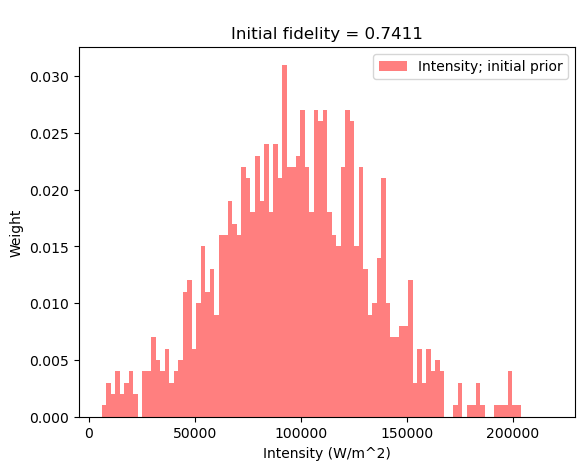

In [517]:
Random.seed!(1)

# Reinitialize the prior
weights_I_1d = deepcopy(weights_I_1d_initial);
particles_I_1d = deepcopy(particles_I_1d_initial);

# Initial theta
# I_INITIAL = + 3*œÉ_I
I_INITIAL = 2*Œº_I
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    Œº_ŒΩ,
    I_INITIAL,
    C0/Œº_f_cl,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
phase!(MS_CHAMBER_UNTUNED.lasers[1], Œº_œï)
phase!(MS_CHAMBER_UNTUNED.lasers[2], Œº_œï)

# Initial belief about theta
I_bar = sum(particles_I_1d .* weights_I_1d)

# Initial fidelity
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
œÅ = dm(sol[end])
fid = real(fidelity(œÅ, œÅ_00_p_i11 ‚äó dm0_VIB_MODE))

particles_I_1d_binned_initial, weights_I_1d_binned_initial, binwidth_I_1d_initial = bin_prior(particles_I_1d_initial, weights_I_1d_initial, 100)
fig = plt.figure()
plt.bar(particles_I_1d_binned_initial, weights_I_1d_binned_initial, width = binwidth_I_1d_initial, color="r", label = "Intensity; initial prior", alpha=0.5)
plt.title("\nInitial fidelity = $(round(fid, digits=4))")
plt.xlabel("Intensity (W/m^2)")
plt.ylabel("Weight")
plt.legend()
plt.display(fig)
plt.close(fig)


## 2.b. Calibrate

In [518]:
loop = 0
I_fid_tracker = [fid]
I_tracker = [I_INITIAL]
I_bar_tracker = [I_bar]
while fid < FID_THRESH
    loop += 1
    if loop > MAX_LOOPS
        break
    end

    # Perform measurements 
    h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
    œÅ = dm(sol[end])
    fid = real(fidelity(œÅ, œÅ_TARGET))
    probs = ZZ_probs(œÅ)
    probs = probs ./ sum(probs)
    m_t = rand(Categorical([p for p in probs]), N_SHOTS)

    # Update beliefs
    # p_m_given_theta = m_given_I_1d_dist[:, m_t]
    # p_m_given_theta = mean(p_m_given_theta, dims=2)
    # weights_I_1d = weights_I_1d .* p_m_given_theta

    # Resample
    if loop%Int(5)==0
        print("\n\nResampling...")
        particles_I_1d, weights_I_1d = LiuWestResampling(particles_I_1d, weights_I_1d, 0.1, m_t, m_given_I_1d_dist)
        print("\n\n")
        flush(stdout)
    end

    # Update beliefs
    for i in 1:N_PARTICLES 
        w_i = weights_I_1d[i]
        theta_i = particles_I_1d[i]
        p_m_given_I_1d_dist = m_given_I_1d_dist[i, :]
        p_m = mean(p_m_given_I_1d_dist[m_t])
        weights_I_1d[i] = w_i * p_m
    end
    weights_I_1d = weights_I_1d ./ sum(weights_I_1d)
    I_bar = sum(particles_I_1d .* weights_I_1d)
    
    # Update parameters
    I_new = compute_I_new(MS_CHAMBER_UNTUNED, I_bar)
    I = I_new
    update_intensity(MS_CHAMBER_UNTUNED, I)

    append!(I_fid_tracker, fid)
    append!(I_tracker, I_new)
    append!(I_bar_tracker, I_bar)
    print("\nI = ", I, ", I_bar = ", I_bar, ", fid = ", fid)
    flush(stdout)

end

In [519]:
loop

30

## 2.c. Analyze results

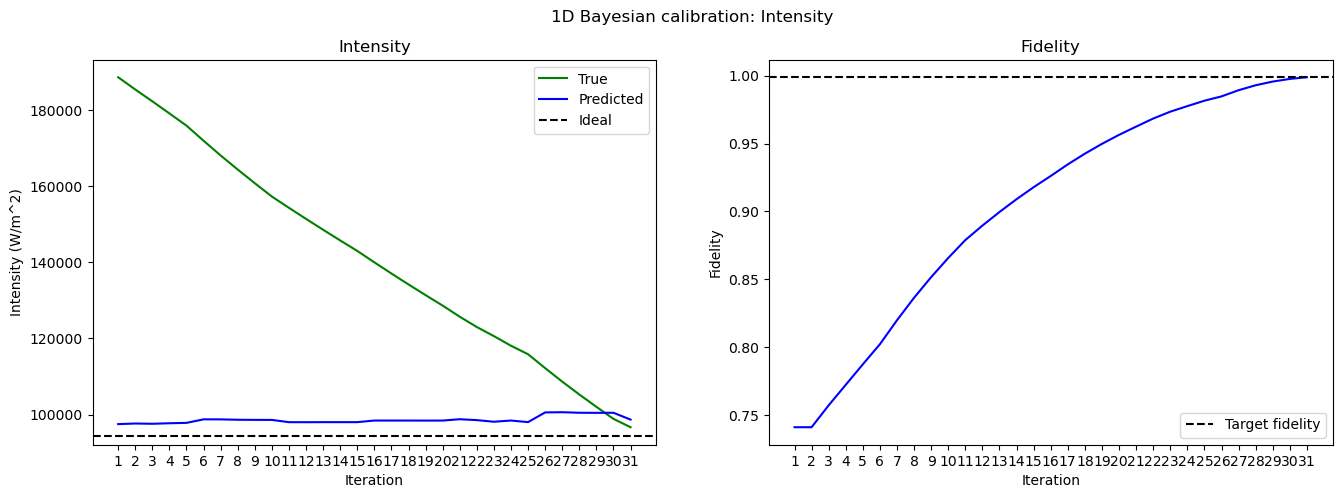

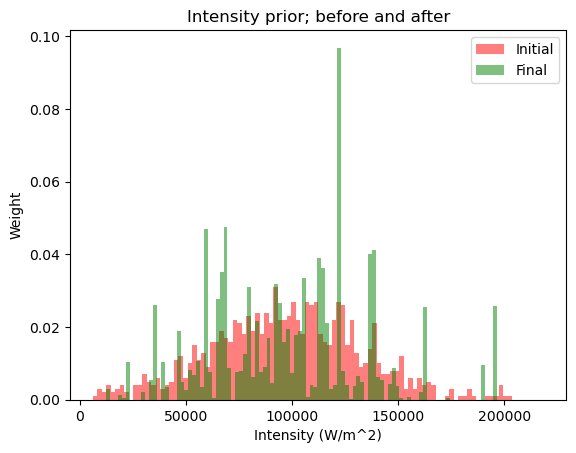

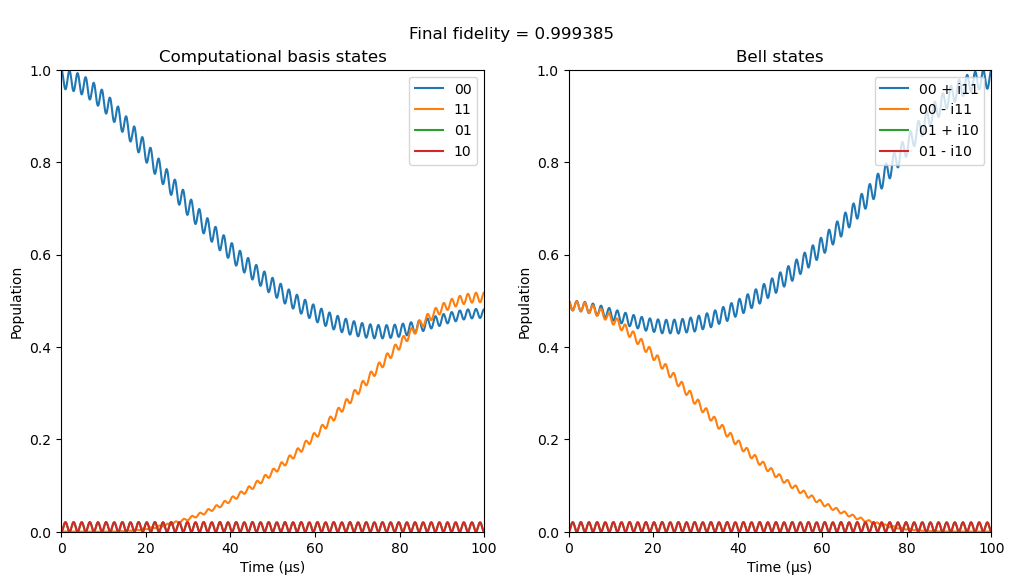

In [520]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.plot(1:length(I_tracker), I_tracker, color="g", label = "True")
ax1.plot(1:length(I_bar_tracker), I_bar_tracker, color="b", label = "Predicted")
ax1.axhline(Œº_I, color="k", linestyle="--", label = "Ideal")
ax1.set_xticks(ticks=1:length(I_tracker))
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Intensity (W/m^2)")
ax1.set_title("Intensity")
ax1.legend()
ax2.plot(1:length(I_fid_tracker), I_fid_tracker, color="b")
ax2.axhline(FID_THRESH, label = "Target fidelity", color="k", linestyle="--")
ax2.set_xticks(ticks=1:length(I_fid_tracker))
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Fidelity")
ax2.set_title("Fidelity")
ax2.legend()
fig.suptitle("1D Bayesian calibration: Intensity")
plt.display(fig)
plt.close(fig)

particles_I_1d_binned_final, weights_I_1d_binned_final, binwidth_I_1d_final = bin_prior(particles_I_1d, weights_I_1d, 100)
fig = plt.figure()
plt.bar(particles_I_1d_binned_initial, weights_I_1d_binned_initial, width = binwidth_I_1d_initial, color="r", label = "Initial", alpha=0.5)
plt.bar(particles_I_1d_binned_final, weights_I_1d_binned_final, width = binwidth_I_1d_final, color="g", label = "Final", alpha=0.5)
plt.title("Intensity prior; before and after")
plt.xlabel("Intensity (W/m^2)")
plt.ylabel("Weight")
plt.legend()
plt.display(fig)
plt.close(fig)

h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
œÅ = ptrace(dm(sol[end]),3)
fid = real(fidelity(œÅ, œÅ_00_p_i11))
fig = plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)
plt.suptitle("\nFinal fidelity = $(round(fid, digits=6))")
plt.display(fig)
plt.close(fig)

**IMPORTANT TODO:** Investigate runaway effect when $\texttt{I\_initial} < \texttt{INTENSITY\_MS}$ and $\texttt{1 - FID\_THRESH}$ is too small; recall Lukas: "the way you do the sampling is tricky, but important"

# 3. Calibrating: Center-line frequency

## 3.a. Initialize in uncalibrated state

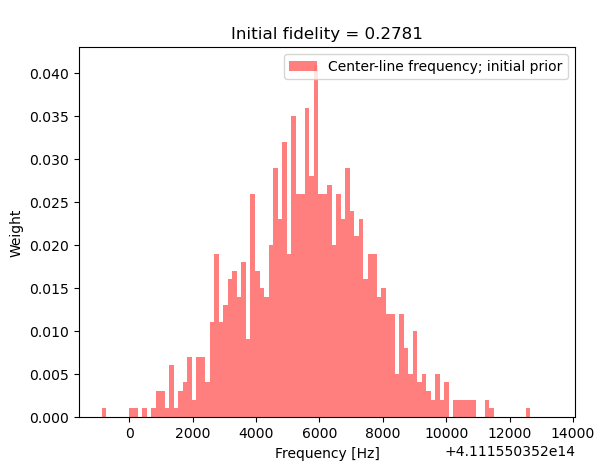

In [521]:
Random.seed!(1)

# Reinitialize the prior
weights_f_cl_1d = deepcopy(weights_f_cl_1d_initial);
particles_f_cl_1d = deepcopy(particles_f_cl_1d_initial);

# Initial theta
# F_CL_INITIAL = Œº_f_cl + 3*œÉ_f_cl
# Œª_CL_INITIAL = C0/F_CL_INITIAL

Œª_CL_INITIAL = C0/Œº_f_cl + Œ¥Œª_MAX*1e-2
F_CL_INITIAL = C0/Œª_CL_INITIAL

MS_CHAMBER_UNTUNED = construct_MS_chamber(
    Œº_ŒΩ,
    Œº_I,
    C0/F_CL_INITIAL,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
phase!(MS_CHAMBER_UNTUNED.lasers[1], Œº_œï)
phase!(MS_CHAMBER_UNTUNED.lasers[2], Œº_œï)

# Initial belief about theta
f_cl_bar = sum(particles_f_cl_1d .* weights_f_cl_1d)

# Initial fidelity
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
œÅ = ptrace(dm(sol[end]),3)
fid = real(fidelity(œÅ, œÅ_00_p_i11))

particles_f_cl_1d_binned_initial, weights_f_cl_1d_binned_initial, binwidth_f_cl_1d_initial = bin_prior(particles_f_cl_1d_initial, weights_f_cl_1d_initial, 100)
fig = plt.figure()
plt.bar(particles_f_cl_1d_binned_initial, weights_f_cl_1d_binned_initial, width = binwidth_f_cl_1d_initial, color="r", label = "Center-line frequency; initial prior", alpha=0.5)
plt.title("\nInitial fidelity = $(round(fid, digits=4))")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Weight")
plt.legend()
plt.display(fig)
plt.close(fig)

## 3.b. Calibrate

In [522]:
loop = 0
f_cl_fid_tracker = [fid]
f_cl_tracker = [F_CL_INITIAL]
f_cl_bar_tracker = [f_cl_bar]
while fid < FID_THRESH
    loop += 1
    if loop > MAX_LOOPS
        break
    end

    print("\n\nf_cl = ", C0/MS_CHAMBER_UNTUNED.lasers[1].Œª, ", Œ¥Œª_cl = ", abs(MS_CHAMBER_UNTUNED.lasers[1].Œª - C0/Œº_f_cl))

    # Perform measurements 
    h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
    œÅ = dm(sol[end])
    fid = real(fidelity(œÅ, œÅ_TARGET))
    probs = ZZ_probs(œÅ)
    probs = probs ./ sum(probs)
    m_t = rand(Categorical([p for p in probs]), N_SHOTS)

    # Resample
    if loop%Int(1e1)==0
        print("\n\nResampling...")
        particles_f_cl_1d, weights_f_cl_1d = LiuWestResampling(particles_f_cl_1d, weights_f_cl_1d, 0.1, m_t, m_given_f_cl_1d_dist)
        print("\n\n")
        flush(stdout)
    end

    # Update beliefs
    for i in 1:N_PARTICLES
        w_i = weights_f_cl_1d[i]
        theta_i = particles_f_cl_1d[i]
        p_m_given_f_cl_1d_dist = m_given_f_cl_1d_dist[i, :]
        p_m = mean(p_m_given_f_cl_1d_dist[m_t])
        weights_f_cl_1d[i] = w_i * p_m
    end
    weights_f_cl_1d = weights_f_cl_1d ./ sum(weights_f_cl_1d)
    f_cl_bar = sum(particles_f_cl_1d .* weights_f_cl_1d)
    
    # Update parameters
    f_cl_new = compute_f_cl_new(MS_CHAMBER_UNTUNED, f_cl_bar)
    Œª_cl_new = C0/f_cl_new
    Œ¥Œª_cl_new = abs(C0/Œº_f_cl - Œª_cl_new)
    if Œ¥Œª_cl_new > Œ¥Œª_MAX
        print("Runaway into non-integrable region")
        flush(stdout)
        break
    end
    update_f_cl(MS_CHAMBER_UNTUNED, f_cl_new)

    append!(f_cl_fid_tracker, fid)
    append!(f_cl_tracker, f_cl_new)
    append!(f_cl_bar_tracker, f_cl_bar)
    print(", f_cl_bar = ", f_cl_bar, "\nf_cl_new = ", f_cl_new,  ", Œ¥Œª_cl_new = ", abs(C0/Œº_f_cl - C0/f_cl_new),  ", fid = ", fid)
    flush(stdout)

end

In [523]:
loop

78

## 3.c. Analyze results

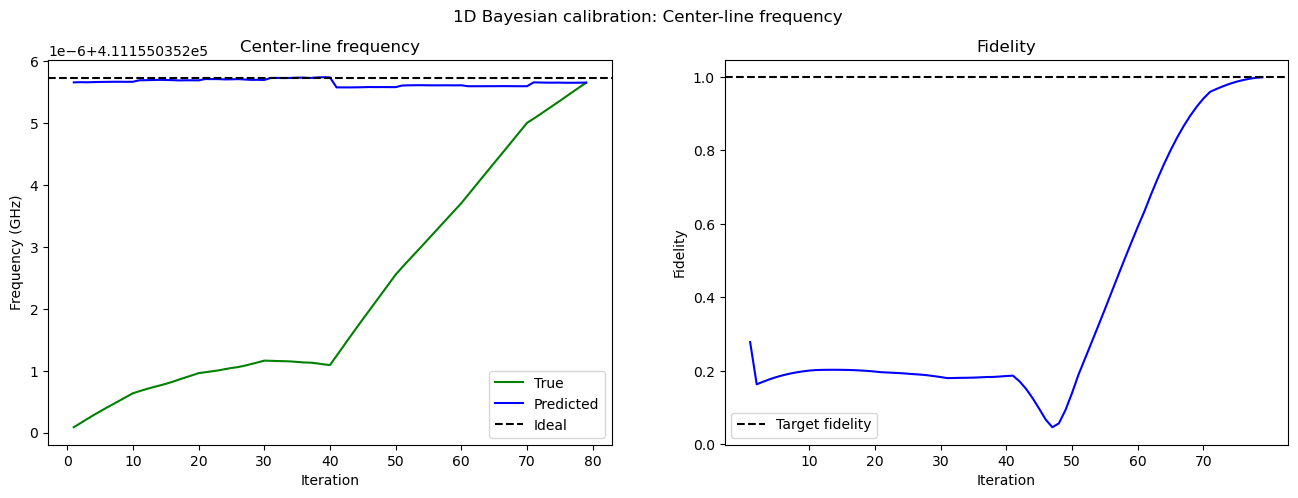

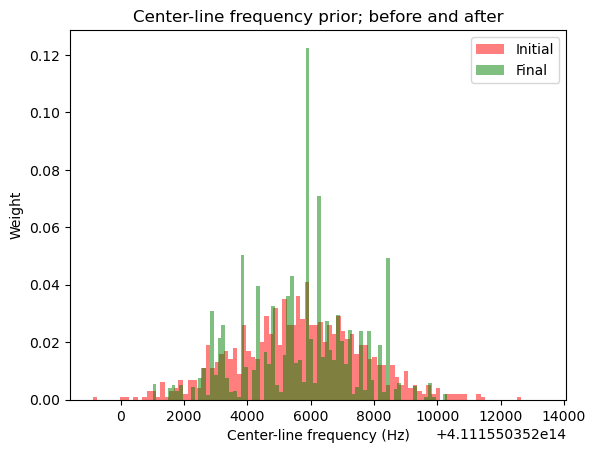

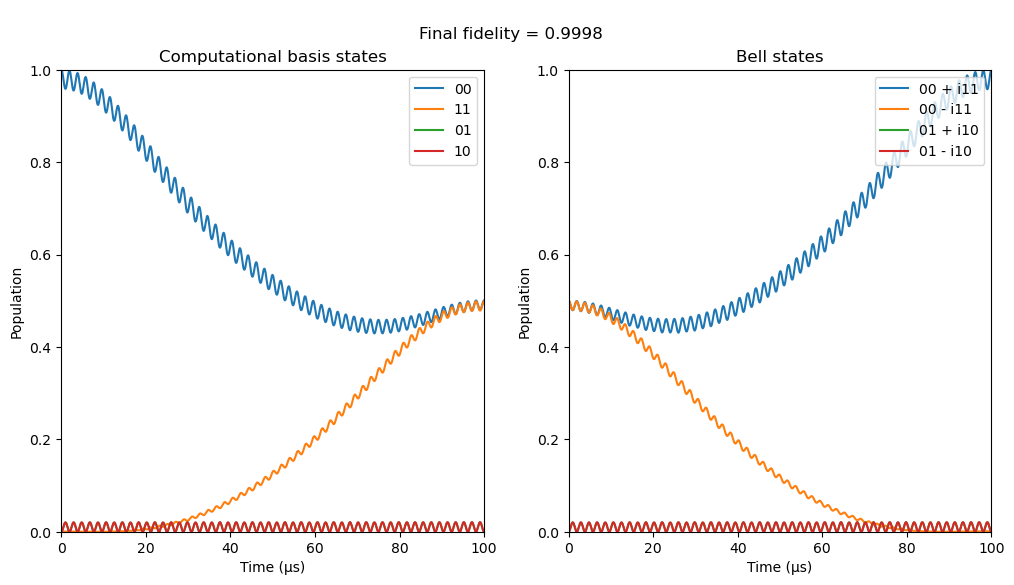

In [524]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.plot(1:length(f_cl_tracker), f_cl_tracker*1e-9, color="g", label = "True")
ax1.plot(1:length(f_cl_bar_tracker), f_cl_bar_tracker*1e-9, color="b", label = "Predicted")
ax1.axhline(Œº_f_cl*1e-9, color="k", linestyle="--", label = "Ideal")
ax2.set_xticks(ticks=[i for i in 1:length(f_cl_tracker) if i%10==0])
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Frequency (GHz)")
ax1.set_title("Center-line frequency")
ax1.legend()
ax2.plot(1:length(f_cl_fid_tracker), f_cl_fid_tracker, color="b")
ax2.axhline(FID_THRESH, label = "Target fidelity", color="k", linestyle="--")
ax2.set_xticks(ticks=[i for i in 1:length(f_cl_fid_tracker) if i%10==0])
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Fidelity")
ax2.set_title("Fidelity")
ax2.legend()
fig.suptitle("1D Bayesian calibration: Center-line frequency")
plt.display(fig)
plt.close(fig)

particles_f_cl_1d_binned_final, weights_f_cl_1d_binned_final, binwidth_f_cl_1d_final = bin_prior(particles_f_cl_1d, weights_f_cl_1d, 100)
fig = plt.figure()
plt.bar(particles_f_cl_1d_binned_initial, weights_f_cl_1d_binned_initial, width = binwidth_f_cl_1d_initial, color="r", label = "Initial", alpha=0.5)
plt.bar(particles_f_cl_1d_binned_final, weights_f_cl_1d_binned_final, width = binwidth_f_cl_1d_final, color="g", label = "Final", alpha=0.5)
plt.title("Center-line frequency prior; before and after")
plt.xlabel("Center-line frequency (Hz)")
plt.ylabel("Weight")
plt.legend()
plt.display(fig)
plt.close(fig)

h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
œÅ = ptrace(dm(sol[end]),3)
fid = real(fidelity(œÅ, œÅ_00_p_i11))
fig = plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)
plt.suptitle("\nFinal fidelity = $(round(fid, digits=4))")
plt.display(fig)
plt.close(fig)

**NOTE:** Sometimes it performs better using $\texttt{FINITE\_RWA\_CUTOFF = 5}$ rather than $\texttt{Inf}$

# 4. Calibrating: Trap frequency

## 4.a. Initialize in uncalibrated state

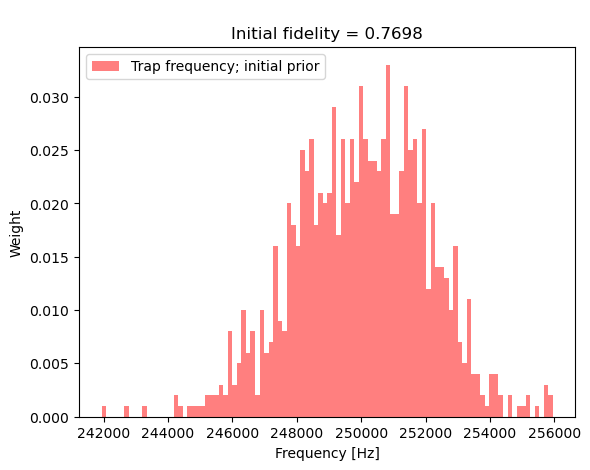

In [525]:
Random.seed!(1)

# Reinitialize the prior
weights_ŒΩ_1d = deepcopy(weights_ŒΩ_1d_initial);
particles_ŒΩ_1d = deepcopy(particles_ŒΩ_1d_initial);

# Initial theta
# ŒΩ_INITIAL = Œº_ŒΩ + 3*œÉ_ŒΩ
ŒΩ_INITIAL = 1.01*Œº_ŒΩ 
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    ŒΩ_INITIAL,
    Œº_I,
    C0/Œº_f_cl,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
phase!(MS_CHAMBER_UNTUNED.lasers[1], Œº_œï)
phase!(MS_CHAMBER_UNTUNED.lasers[2], Œº_œï)

# Remember, the detuning is based on the target trap-frequency, not the true trap-frequency
MS_CHAMBER_UNTUNED.lasers[1].Œî = Œº_ŒΩ+ DETUNING - AC_CORRECTION
MS_CHAMBER_UNTUNED.lasers[2].Œî = -(Œº_ŒΩ + DETUNING - AC_CORRECTION)

# Initial belief about theta
ŒΩ_bar = sum(particles_ŒΩ_1d .* weights_ŒΩ_1d)

# Initial fidelity
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
œÅ = ptrace(dm(sol[end]),3)
fid = real(fidelity(œÅ, œÅ_00_p_i11))

particles_ŒΩ_1d_binned_initial, weights_ŒΩ_1d_binned_initial, binwidth_ŒΩ_1d_initial = bin_prior(particles_ŒΩ_1d_initial, weights_ŒΩ_1d_initial, 100)
fig = plt.figure()
plt.bar(particles_ŒΩ_1d_binned_initial, weights_ŒΩ_1d_binned_initial, width = binwidth_ŒΩ_1d_initial, color="r", label = "Trap frequency; initial prior", alpha=0.5)
plt.title("\nInitial fidelity = $(round(fid, digits=4))")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Weight")
plt.legend()
plt.display(fig)
plt.close(fig)

## 4.b. Calibrate

In [526]:
loop = 0
ŒΩ_fid_tracker = []
ŒΩ_tracker = [ŒΩ_INITIAL]
ŒΩ_bar_tracker = [ŒΩ_bar]
while fid < FID_THRESH
    loop += 1
    if loop > MAX_LOOPS
        break
    end

    # Perform measurements 
    h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
    œÅ = dm(sol[end])
    fid = real(fidelity(œÅ, œÅ_TARGET))
    probs = ZZ_probs(œÅ)
    probs = probs ./ sum(probs)
    m_t = rand(Categorical([p for p in probs]), N_SHOTS)

    # Resample
    if loop%Int(1e1)==0
        # Resample
        print("\n\nResampling...")
        particles_ŒΩ_1d, weights_ŒΩ_1d = LiuWestResampling(particles_ŒΩ_1d, weights_ŒΩ_1d, 0.1, m_t, m_given_ŒΩ_1d_dist)
        print("\n\n")
        flush(stdout)
    end

    # Update beliefs
    for i in 1:N_PARTICLES
        w_i = weights_ŒΩ_1d[i]
        theta_i = particles_ŒΩ_1d[i]
        p_m_given_ŒΩ_1d_dist = m_given_ŒΩ_1d_dist[i, :]
        p_m = mean(p_m_given_ŒΩ_1d_dist[m_t])
        weights_ŒΩ_1d[i] = w_i * p_m
    end
    weights_ŒΩ_1d = weights_ŒΩ_1d ./ sum(weights_ŒΩ_1d)
    ŒΩ_bar = sum(particles_ŒΩ_1d .* weights_ŒΩ_1d)
    
    # Update parameters
    ŒΩ_new = compute_ŒΩ_new(MS_CHAMBER_UNTUNED, ŒΩ_bar)
    MS_CHAMBER_UNTUNED = update_ŒΩ(MS_CHAMBER_UNTUNED, ŒΩ_new)

    append!(ŒΩ_fid_tracker, fid)
    append!(ŒΩ_tracker, ŒΩ_new)
    append!(ŒΩ_bar_tracker, ŒΩ_bar)
    print("\nŒΩ_bar = ", ŒΩ_bar, ", ŒΩ_new = ", ŒΩ_new, ", fid = ", fid)
    flush(stdout)


end

In [527]:
loop

71

## 4.c. Analyze results

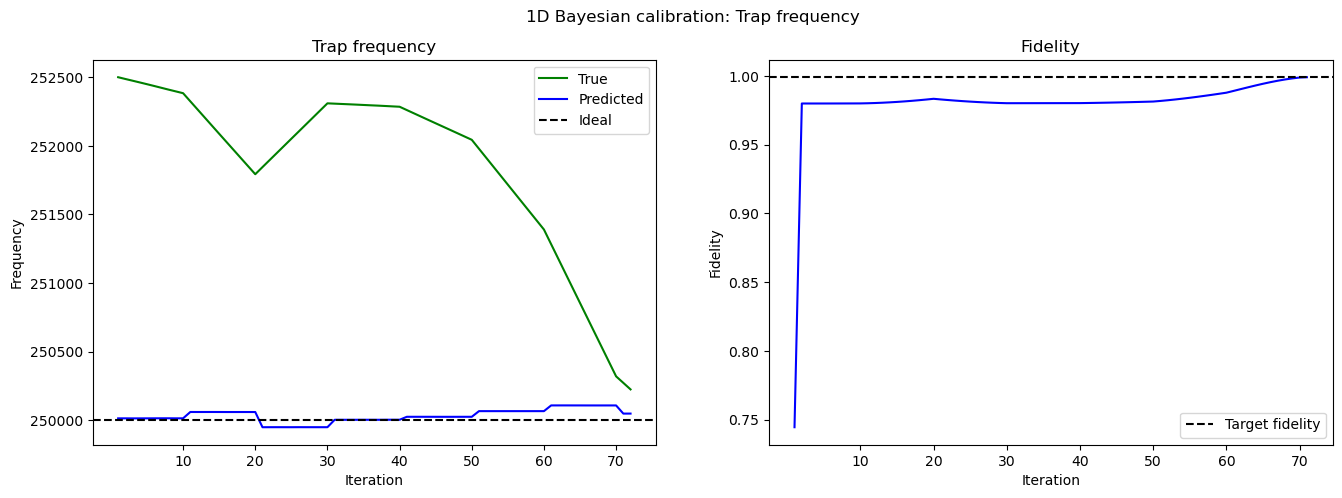

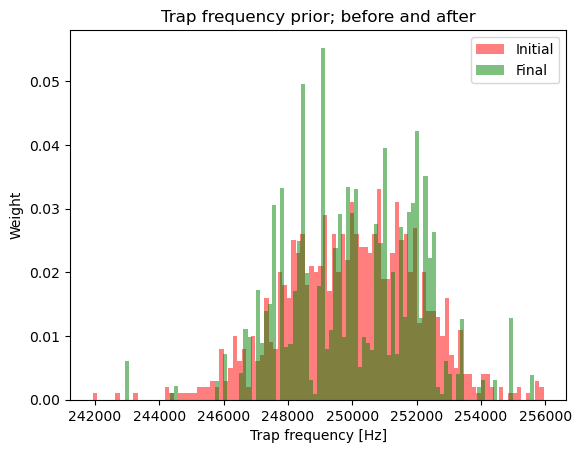

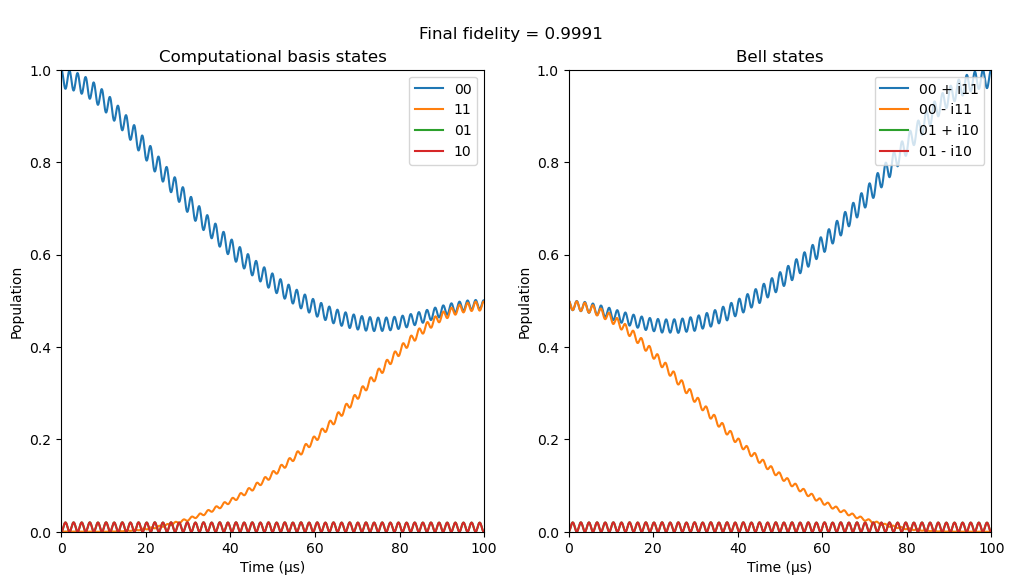

In [528]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.plot(1:length(ŒΩ_tracker), ŒΩ_tracker, color="g", label = "True")
ax1.plot(1:length(ŒΩ_bar_tracker), ŒΩ_bar_tracker, color="b", label = "Predicted")
ax1.axhline(Œº_ŒΩ, color="k", linestyle="--", label = "Ideal")
ax1.set_xticks(ticks=[i for i in 1:length(ŒΩ_fid_tracker) if i%10==0])
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Frequency")
ax1.set_title("Trap frequency")
ax1.legend()
ax2.plot(1:length(ŒΩ_fid_tracker), ŒΩ_fid_tracker, color="b")
ax2.axhline(FID_THRESH, label = "Target fidelity", color="k", linestyle="--")
ax2.set_xticks(ticks=[i for i in 1:length(ŒΩ_fid_tracker) if i%10==0])
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Fidelity")
ax2.set_title("Fidelity")
ax2.legend()
fig.suptitle("1D Bayesian calibration: Trap frequency")
plt.display(fig)
plt.close(fig)

particles_ŒΩ_1d_binned_final, weights_ŒΩ_1d_binned_final, binwidth_ŒΩ_1d_final = bin_prior(particles_ŒΩ_1d, weights_ŒΩ_1d, 100)
fig = plt.figure()
plt.bar(particles_ŒΩ_1d_binned_initial, weights_ŒΩ_1d_binned_initial, width = binwidth_ŒΩ_1d_initial, color="r", label = "Initial", alpha=0.5)
plt.bar(particles_ŒΩ_1d_binned_final, weights_ŒΩ_1d_binned_final, width = binwidth_ŒΩ_1d_final, color="g", label = "Final", alpha=0.5)
plt.title("Trap frequency prior; before and after")
plt.xlabel("Trap frequency [Hz]")
plt.ylabel("Weight")
plt.legend()
plt.display(fig)
plt.close(fig)

h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
œÅ = ptrace(dm(sol[end]),3)
fid = real(fidelity(œÅ, œÅ_00_p_i11))
fig = plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)
plt.suptitle("\nFinal fidelity = $(round(fid, digits=4))")
plt.display(fig)
plt.close(fig)

**TODO:** This is weird. Why does fidelity decrease as trap-frequency strays from the "ideal"?

Interesting that it sometimes develops these sidebands. Sara says this might be due to AC stark shift. 

# 5. Calibrating: Phase

## 5.a. Initialize in uncalibrated state

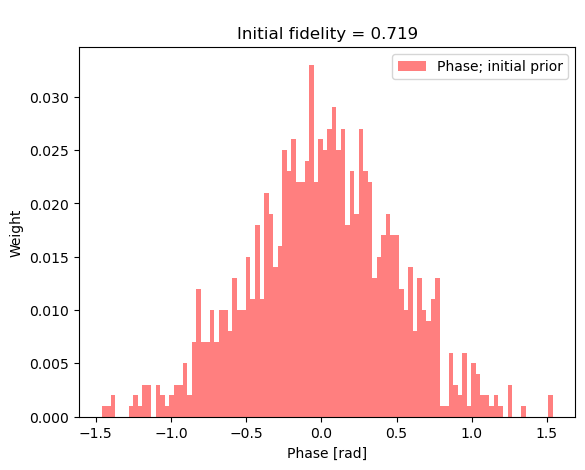

In [529]:
Random.seed!(1)

weights_œï_1d = deepcopy(weights_œï_1d_initial);
particles_œï_1d = deepcopy(particles_œï_1d_initial);

# Initial theta
œï_INITIAL = Œº_œï + 3*œÉ_œï
MS_CHAMBER_UNTUNED = construct_MS_chamber(
    Œº_ŒΩ,
    Œº_I,
    C0/Œº_f_cl,
    DETUNING,
    AC_CORRECTION,
    B_STRENGTH
)
phase!(MS_CHAMBER_UNTUNED.lasers[1], 0)
phase!(MS_CHAMBER_UNTUNED.lasers[2], œï_INITIAL)

# Initial belief about theta
œï_bar = sum(particles_œï_1d .* weights_œï_1d)

# Initial fidelity
h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
œÅ = ptrace(dm(sol[end]),3)
fid = real(fidelity(œÅ, œÅ_00_p_i11))

particles_œï_1d_binned_initial, weights_œï_1d_binned_initial, binwidth_œï_1d_initial = bin_prior(particles_œï_1d_initial, weights_œï_1d_initial, 100)
fig = plt.figure()
plt.bar(particles_œï_1d_binned_initial, weights_œï_1d_binned_initial, width = binwidth_œï_1d_initial, color="r", label = "Phase; initial prior", alpha=0.5)
plt.title("\nInitial fidelity = $(round(fid, digits=4))")
plt.xlabel("Phase [rad]")
plt.ylabel("Weight")
plt.legend()
plt.display(fig)
plt.close(fig)

## 5.b. Calibrate

In [530]:
loop = 0
œï_fid_tracker = []
œï_tracker = [œï_INITIAL]
œï_bar_tracker = [œï_bar]
while fid < FID_THRESH
    loop += 1
    if loop > MAX_LOOPS
        break
    end

    # Perform measurements 
    h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
    tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
    œÅ = dm(sol[end])
    fid = real(fidelity(œÅ, œÅ_TARGET))
    probs = ZZ_probs(œÅ)
    probs = probs ./ sum(probs)
    m_t = rand(Categorical([p for p in probs]), N_SHOTS)

    if loop%Int(1e1)==0
        # Resample
        print("\n\nResampling...")
        particles_œï_1d, weights_œï_1d = LiuWestResampling(particles_œï_1d, weights_œï_1d, 0.1, m_t, m_given_œï_1d_dist)
        print("\n\n")
        flush(stdout)
    end

    # Update beliefs
    for i in 1:N_PARTICLES
        w_i = weights_œï_1d[i]
        theta_i = particles_œï_1d[i]
        p_m_given_œï_1d_dist = m_given_œï_1d_dist[i, :]
        p_m = mean(p_m_given_œï_1d_dist[m_t])
        weights_œï_1d[i] = w_i * p_m
    end
    weights_œï_1d = weights_œï_1d ./ sum(weights_œï_1d)
    œï_bar = sum(particles_œï_1d .* weights_œï_1d)
    
    # Update parameters
    œï_new = compute_œï_new(MS_CHAMBER_UNTUNED, œï_bar)%2œÄ
    update_œï(MS_CHAMBER_UNTUNED, œï_new)

    append!(œï_fid_tracker, fid)
    append!(œï_tracker, œï_new)
    append!(œï_bar_tracker, œï_bar)
    print("\nœï_bar = ", œï_bar, ", œï_new = ", œï_new, ", fid = ", fid)
    flush(stdout)

end

In [531]:
loop

201

b 

## 5.c. Analyze results

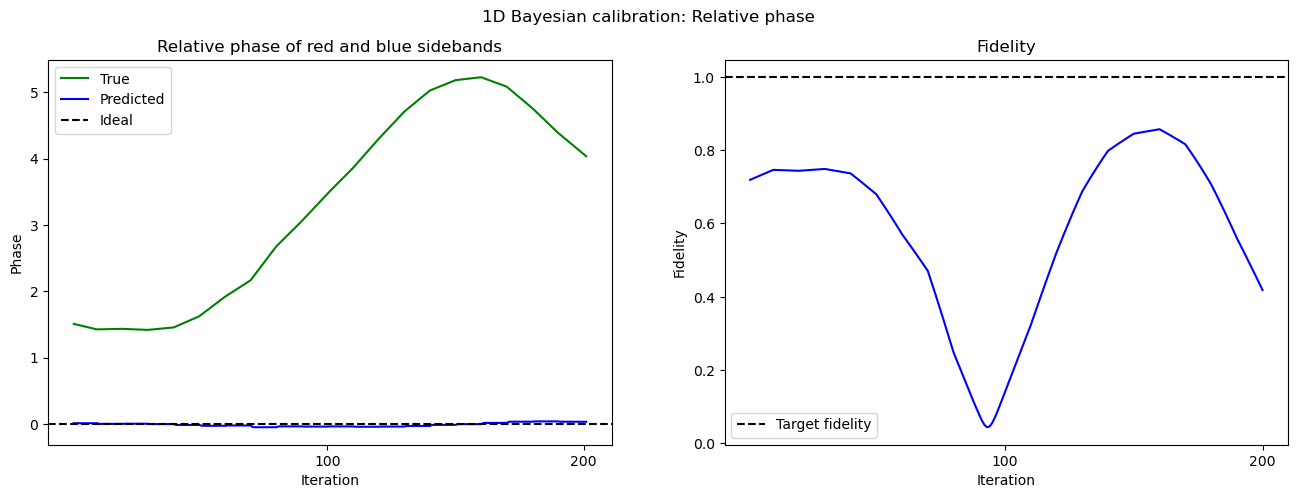

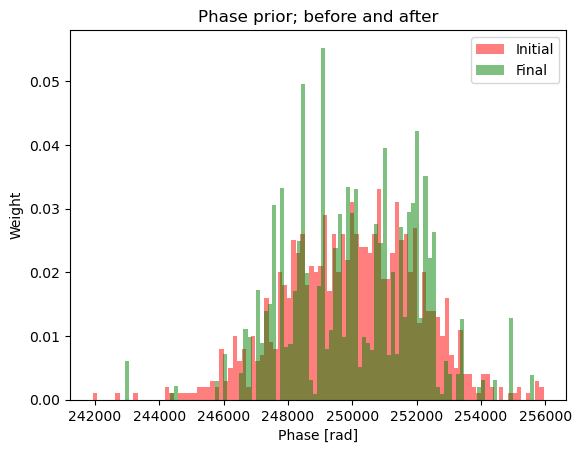

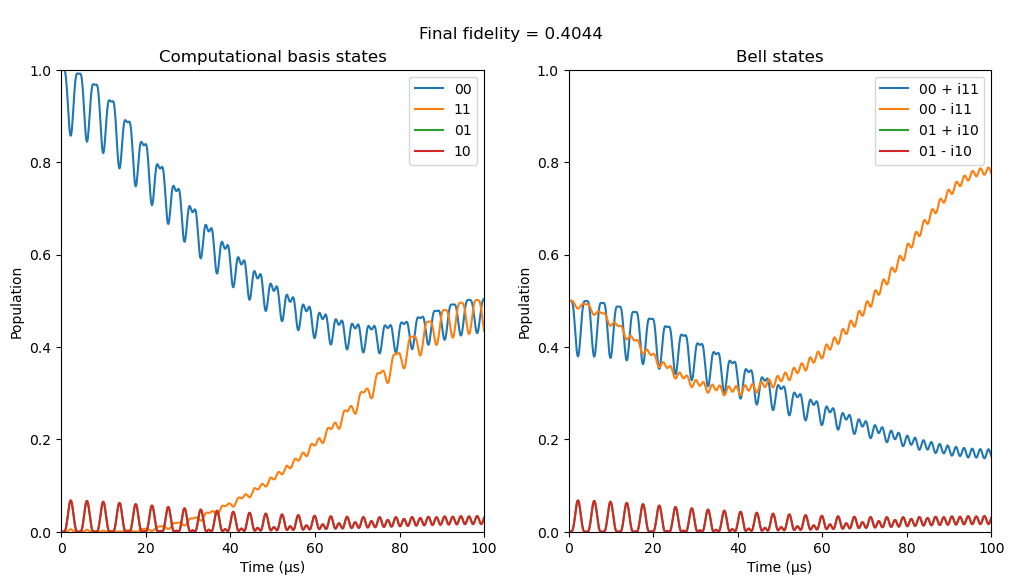

In [532]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.plot(1:length(œï_tracker), œï_tracker, color="g", label = "True")
ax1.plot(1:length(œï_bar_tracker), œï_bar_tracker, color="b", label = "Predicted")
ax1.axhline(Œº_œï, color="k", linestyle="--", label = "Ideal")
ax1.set_xticks(ticks=[i for i in 1:length(œï_tracker) if i%100==0])
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Phase")
ax1.set_title("Relative phase of red and blue sidebands")
ax1.legend()
ax2.plot(1:length(œï_fid_tracker), œï_fid_tracker, color="b")
ax2.axhline(FID_THRESH, label = "Target fidelity", color="k", linestyle="--")
ax2.set_xticks(ticks=[i for i in 1:length(œï_fid_tracker) if i%100==0])
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Fidelity")
ax2.set_title("Fidelity")
ax2.legend()
fig.suptitle("1D Bayesian calibration: Relative phase")
plt.display(fig)
plt.close(fig)

particles_œï_1d_binned_final, weights_œï_1d_binned_final, binwidth_œï_1d_final = bin_prior(particles_œï_1d, weights_œï_1d, 100)
fig = plt.figure()
plt.bar(particles_ŒΩ_1d_binned_initial, weights_ŒΩ_1d_binned_initial, width = binwidth_ŒΩ_1d_initial, color="r", label = "Initial", alpha=0.5)
plt.bar(particles_ŒΩ_1d_binned_final, weights_ŒΩ_1d_binned_final, width = binwidth_ŒΩ_1d_final, color="g", label = "Final", alpha=0.5)
plt.title("Phase prior; before and after")
plt.xlabel("Phase [rad]")
plt.ylabel("Weight")
plt.legend()
plt.display(fig)
plt.close(fig)

h = hamiltonian(MS_CHAMBER_UNTUNED, timescale=TIMESCALE, lamb_dicke_order=1, rwa_cutoff=Inf)
tout, sol = timeevolution.schroedinger_dynamic(T_RANGE/TIMESCALE, ket_00 ‚äó ket0_VIB_MODE, h)
œÅ = ptrace(dm(sol[end]),3)
fid = real(fidelity(œÅ, œÅ_00_p_i11))
fig = plot_populations_double(MS_CHAMBER_UNTUNED, tout, sol)
plt.suptitle("\nFinal fidelity = $(round(fid, digits=4))")
plt.display(fig)
plt.close(fig)